In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Bright sources from 1-dimensional coded mask 


In [13]:
from sympy.ntheory.primetest import isprime
from scipy.linalg import hankel

def linear_ura(L):
    assert(((L - 3) / 4).is_integer())
    assert(isprime(L))
    A = np.zeros(L).astype(int)
    G = np.ones(L).astype(int) # decoding
    A[np.unique(np.mod(np.arange(L) ** 2, L))] = 1
    G[A == 0] = -1
    return A, G

def _pad(A):
    n = int(len(A)/2)
    return np.concatenate((A[-n:], A, A[:n]))

def absorbed(photons, A):
    n = len(A)
    _A = _pad(A) 
    hankel_ura = hankel(_A[:n], _A[n - 1:])
    return hankel_ura[photons[:, 0], photons[:, 1]] == 0

def transport(photons, A):
    transmitted = photons[~absorbed(photons, A)]
    detector, _ = np.histogram(transmitted[:,1], bins=np.arange(len(A) + 1))
    return detector

def decode(detector, G):
    assert(np.all(np.isin(np.unique(G), [1,-1])))
    assert(len(G) == len(detector))
    _G = _pad(G)
    n = len(G)
    norm = np.sum(G[G==1])
    hankel_ura_decoding = hankel(_G[:n], _G[n - 1:])
    return hankel_ura_decoding.dot(detector) #/ norm

We try a different approach:

1. Build the mask. We implement a linear, cyclic URA aperture mask from a sequence with size `mask_size`, according the geometry of Gottesman 2007. This implies that the aperture mask will have appropriate padding resulting in dimension `2*mask_size - 1`.
2. Simulate the background. We sample `nbackground` couples of integers between `0` and `mask_size`. Each couple represent one photons. The elements of one couple represent the photon's source direction and the intercept aperture element. Photons impacting on an open elements are propagated through and added to an array representing counts over different detector elements, while photons intercepting an opaque mask elements are stopped.
3. Simulate a bright signal from some direction. The procedure of 2. is repeated for `nsignal` photons. However, these photons will have the first couple element fixed to a common random integer between `0` and `mask_size`.

We'll keep track of the simulated photon counts by source direction in an array called "source".

In [14]:
np.random.seed(42)

In [15]:
mask_size = 7
A, G = linear_ura(mask_size)

In [16]:
bkg_rate = 0

nbackground = bkg_rate * mask_size
background_photons = np.random.randint(mask_size, size = 2 * nbackground).reshape(-1, 2)

In [17]:
nsignal = 3
signal_dir = np.random.randint(mask_size)
signal_photons = np.stack(
    [
        signal_dir*np.ones(nsignal).astype(int), 
        np.random.randint(mask_size, size = nsignal)
    ], 
    axis = 1
)
print(f"bright signal with direction {signal_dir}")

bright signal with direction 6


In [18]:
photons = np.concatenate((background_photons, signal_photons))
detector = transport(photons, A)

Trying to decode the simulated detector through $S = G * D$ seems to result in garbage.

In [19]:
print(
    "decoded: \t", decode(detector, G),
    "\ndetector: \t", detector, 
    "\ntransmitted: \t", np.histogram(photons[~absorbed(photons, A)][:,0], bins=np.arange(mask_size + 1))[0],
    "\nsource: \t", np.histogram(photons[:,0], bins=np.arange(mask_size + 1))[0],
)

decoded: 	 [ 0  2 -2  0  0  0  2] 
detector: 	 [0 0 0 0 1 0 1] 
transmitted: 	 [0 0 0 0 0 0 2] 
source: 	 [0 0 0 0 0 0 3]


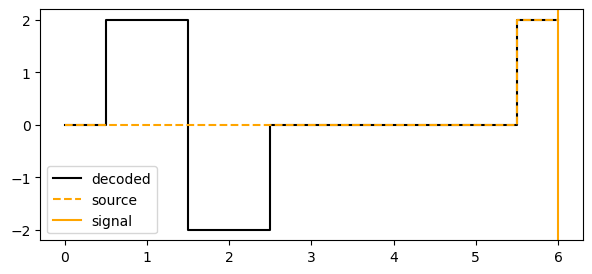

In [20]:
_transmitted = np.histogram(photons[~absorbed(photons, A)][:,0], bins=np.arange(mask_size + 1))[0]

plt.figure(figsize=(7,3))
plt.step(np.arange(mask_size), decode(detector, G), where="mid", label="decoded", c="k")
plt.step(np.arange(mask_size), _transmitted, where="mid", label="source", linestyle="dashed", c="orange")
plt.axvline(signal_dir, c="orange", label="signal")
plt.legend()
plt.show()

In [9]:
def f(detector, A):
    n = len(A)
    _A = _pad(A)
    hankel_ura = hankel(_A[:n], _A[n - 1:])
    M = np.full((n, n), 0.5)
    np.fill_diagonal(M, 1)
    return np.linalg.solve(M, hankel_ura.dot(detector))

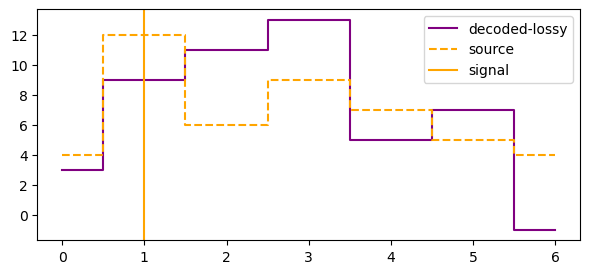

In [10]:
_transmitted = np.histogram(photons[~absorbed(photons, A)][:,0], bins=np.arange(mask_size + 1))[0]

plt.figure(figsize=(7,3))
plt.step(np.arange(mask_size), f(detector, A), where="mid", label="decoded-lossy", c="purple")
plt.step(np.arange(mask_size), _transmitted, where="mid", label="source", linestyle="dashed", c="orange")
plt.axvline(signal_dir, c="orange", label="signal")
plt.legend()
plt.show()

In [11]:
def f1(photons, detector, A):
    n = len(A)
    _A = _pad(A)
    hankel_ura = hankel(_A[:n], _A[n - 1:])
    t = photons[~absorbed(photons, A)]
    c, _, _ = np.histogram2d(t[:,0], t[:,1], bins=np.arange(mask_size+ 1))
    M = np.divide(
        hankel_ura.dot(c.T), 
        np.sum(c, axis = 1), 
        where=(np.sum(c, axis = 1) !=0),
    )
    return np.linalg.solve(M, hankel_ura.dot(detector))

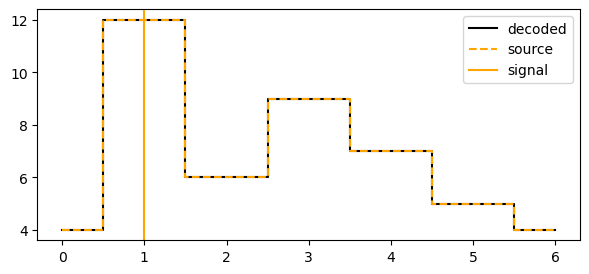

In [12]:
_transmitted = np.histogram(photons[~absorbed(photons, A)][:,0], bins=np.arange(mask_size + 1))[0]

plt.figure(figsize=(7,3))
plt.step(np.arange(mask_size), f1(photons[~absorbed(photons, A)], detector, A), where="mid", label="decoded", c="k")
plt.step(np.arange(mask_size), _transmitted, where="mid", label="source", linestyle="dashed", c="orange")
plt.axvline(signal_dir, c="orange", label="signal")
plt.legend()
plt.show()